In [ ]:
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu

base_path = r'C:\Users\hanaj\OneDrive\문서\[강남구혁신인재육성아카데미]데이터분석\미니프로젝트\국내여행로그데이터'
sub_place = ['동부권', '서부권', '수도권', '제주도 및 도서지역']
sub_folder = ['TS_csv', 'VS_csv']

# 전국 단위 데이터를 쌓기 위한 리스트
travel_merge = []
accomm_con_merge = []
active_con_merge = []
trans_con_merge = []
pre_con_merge = []

for place in sub_place:
    for folder in sub_folder:
        travel_path = base_path + "\\" + place + "\\" + folder

        suffix = {
            '동부권': 'B',
            '서부권': 'C',
            '수도권': 'A',
            '제주도 및 도서지역': 'D'
        }[place]

        travel = pd.read_csv(travel_path + f"\\tn_travel_여행_{suffix}.csv")
        accomm = pd.read_csv(travel_path + f"\\tn_lodge_consume_his_숙박소비내역_{suffix}.csv")
        active = pd.read_csv(travel_path + f"\\tn_activity_consume_his_활동소비내역_{suffix}.csv")
        trans = pd.read_csv(travel_path + f"\\tn_mvmn_consume_his_이동수단소비내역_{suffix}.csv")
        pre = pd.read_csv(travel_path + f"\\tn_adv_consume_his_사전소비내역_{suffix}.csv")

        travel_merge.append(travel)
        accomm_con_merge.append(accomm)
        active_con_merge.append(active)
        trans_con_merge.append(trans)
        pre_con_merge.append(pre)

# ==== 여기서부터 전국 단위 합치기 ====
travel_merge_all = pd.concat(travel_merge).reset_index(drop=True)
accomm_con_merge_all = pd.concat(accomm_con_merge).reset_index(drop=True)
active_con_merge_all = pd.concat(active_con_merge).reset_index(drop=True)
trans_con_merge_all = pd.concat(trans_con_merge).reset_index(drop=True)
pre_con_merge_all = pd.concat(pre_con_merge).reset_index(drop=True)

travel_merge_all['TRAVEL_END_YMD'] = pd.to_datetime(travel_merge_all['TRAVEL_END_YMD'])
travel_merge_all['TRAVEL_START_YMD'] = pd.to_datetime(travel_merge_all['TRAVEL_START_YMD'])
travel_merge_all['TRAVEL_DAYS'] = (travel_merge_all['TRAVEL_END_YMD'] - travel_merge_all['TRAVEL_START_YMD']).dt.days

TravelID = travel_merge_all[['TRAVEL_ID', 'TRAVEL_DAYS']]
accomm_con_sel = accomm_con_merge_all[['TRAVEL_ID', 'LODGING_TYPE_CD', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '숙박결제금액'})
active_con_sel = active_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '활동결제금액'})
trans_con_sel = trans_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '교통결제금액'})
pre_con_sel = pre_con_merge_all[['TRAVEL_ID', 'PAYMENT_AMT_WON']].rename(columns={'PAYMENT_AMT_WON': '사전결제금액'})

accomm_drop = accomm_con_sel.drop_duplicates(subset=['TRAVEL_ID', 'LODGING_TYPE_CD', '숙박결제금액'])
accomm_sum = accomm_drop.groupby(['TRAVEL_ID', 'LODGING_TYPE_CD'], as_index=False)['숙박결제금액'].sum()
active_sum = active_con_sel.groupby(['TRAVEL_ID'], as_index=False)['활동결제금액'].sum()
trans_sum = trans_con_sel.groupby(['TRAVEL_ID'], as_index=False)['교통결제금액'].sum()
pre_con_sum = pre_con_sel.groupby(['TRAVEL_ID'], as_index=False)['사전결제금액'].sum()

all_merge = pd.merge(TravelID, accomm_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, active_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, trans_sum, on='TRAVEL_ID', how='left')
all_merge = pd.merge(all_merge, pre_con_sum, on='TRAVEL_ID', how='left')

all_merge['전체결제금액'] = all_merge[['활동결제금액', '교통결제금액', '사전결제금액']].sum(axis=1, skipna=True)

day_trip = all_merge[all_merge['LODGING_TYPE_CD'].isna()].reset_index(drop=True)
lodgment = all_merge[all_merge['LODGING_TYPE_CD'].notna()].reset_index(drop=True)

long_trip = day_trip[day_trip['TRAVEL_DAYS'] >= 3]
lodgment = pd.concat([lodgment, long_trip], ignore_index=True)
day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 3]

day_trip = day_trip[day_trip['TRAVEL_DAYS'] < 10]
lodgment = lodgment[lodgment['TRAVEL_DAYS'] < 10]

lodgment = lodgment.drop_duplicates('TRAVEL_ID', keep='first')
day_trip['전체결제금액'] = day_trip['전체결제금액'] / day_trip['TRAVEL_DAYS']
lodgment['전체결제금액'] = lodgment['전체결제금액'] / lodgment['TRAVEL_DAYS']

# 전국 데이터로 검정    
day_trip_group = day_trip[['전체결제금액']]
lodgment_group = lodgment[['전체결제금액']]

print("전국 단위 당일치기 vs 숙박 여행자 비교")

stats, pvalue = shapiro(day_trip_group)
print("당일치기의 정규성 검증 : ", pvalue)

stats, pvalue = shapiro(lodgment_group)
print("숙박여행자의 정규성 검증 : ", pvalue)

stat, p = mannwhitneyu(day_trip_group, lodgment_group, alternative='two-sided')
print("mann-whitney-U 검정 : ", p[0])

if p[0] < 0.05:
    print("전국 단위로 당일치기와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다")
else:
    print("전국 단위로 당일치기와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 같다.")


전국 단위 당일치기 vs 숙박 여행자 비교
당일치기의 정규성 검증 :  2.3685736569076273e-88
숙박여행자의 정규성 검증 :  1.463321600325324e-85
mann-whitney-U 검정 :  1.6913110257216484e-179
전국 단위로 당일치기와 숙박 여행자의 전체 결제 금액 분포는 서로 유의미하게 다르다


c:\Users\hanaj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6623.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hanaj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7762.
  res = hypotest_fun_out(*samples, **kwds)


C:\Users\hanaj\AppData\Local\Temp\ipykernel_22844\3041439653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_trip_group['구분'] = '당일치기'
C:\Users\hanaj\AppData\Local\Temp\ipykernel_22844\3041439653.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lodgment_group['구분'] = '숙박'
C:\Users\hanaj\AppData\Local\Temp\ipykernel_22844\3041439653.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False`

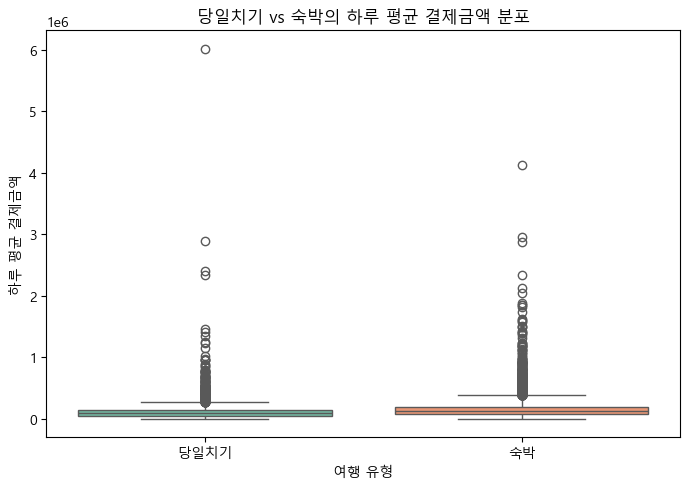

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 가정: day_trip_group과 lodgment_group은 Series 형태
day_trip_group['구분'] = '당일치기'
lodgment_group['구분'] = '숙박'

# 하나로 합치기
group_df = pd.concat([day_trip_group, lodgment_group])
group_df.columns = ['전체결제금액', '구분']

# 박스플롯 그리기
plt.figure(figsize=(7, 5))
sns.boxplot(data=group_df, x='구분', y='전체결제금액', palette='Set2')
plt.title('당일치기 vs 숙박의 하루 평균 결제금액 분포')
plt.ylabel('하루 평균 결제금액')
plt.xlabel('여행 유형')
plt.tight_layout()
plt.show()
